In [20]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

## Choropleth maps: SPEI and forest loss

In [4]:
# load shapefile
gdf = gpd.read_file('Data/district.shp')

# load forest loss data
loss_df = pd.read_csv('Data/district_forest_cover.csv')

# get only 2020 values
loss_df_2020 = loss_df[loss_df['year'] == 2020].copy()

loss_df_2020['forest_2000_ha'] = loss_df_2020['forest_2000_m2'] / 10000

# strip district names to avoid merge mismatch
loss_df_2020['district'] = loss_df_2020['district'].str.strip()

# merge on district name
merged = gdf.merge(loss_df_2020, on='district', how='left')
merged['percent_change'] = ((merged['forest_cover_ha'] - merged['forest_2000_ha']) / merged['forest_2000_ha']) * 100

# load growing season SPEI data  
spei_df = pd.read_csv('Data/district_province_spei_growingperiod.csv')

avg_spei = spei_df.groupby('district')['mean_growing_spei'].mean().reset_index()

merged_spei = merged.merge(avg_spei, on='district', how='left')

merged_spei.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,district,year,forest_cover_ha,loss_m2,percent_loss_annual,forest_2000_m2,log_loss_m2,forest_2000_ha,percent_change,mean_growing_spei
0,ZMB.1.1_2,ZMB,Zambia,ZMB.1_1,Central,NA,Chibombo,NA,NA,District,...,Chibombo,2020,40050.248994,9.133035e+06,2.229551,5.659373e+08,16.027409,56593.726083,-29.231998,0.434347
1,ZMB.1.2_2,ZMB,Zambia,ZMB.1_1,Central,NA,Chisamba,NA,NA,District,...,Chisamba,2020,21103.253088,1.708615e+06,0.803142,2.281906e+08,14.351194,22819.058458,-7.519177,0.418814
2,ZMB.1.3_2,ZMB,Zambia,ZMB.1_1,Central,NA,Chitambo,NA,NA,District,...,Chitambo,2020,363953.361403,2.399853e+07,0.655065,3.912604e+09,16.993503,391260.437170,-6.979258,0.296704
3,ZMB.1.4_2,ZMB,Zambia,ZMB.1_1,Central,NA,Itezhi-tezhi,NA,NA,District,...,Itezhi-tezhi,2020,66746.383398,7.085123e+06,1.050350,7.189793e+08,15.773508,71897.933599,-7.165088,0.456060
4,ZMB.1.5_2,ZMB,Zambia,ZMB.1_1,Central,NA,Kabwe,NA,NA,District,...,Kabwe,2020,14067.887573,1.998846e+06,1.400952,1.612138e+08,14.508081,16121.379990,-12.737696,0.458841


<Figure size 2000x1600 with 0 Axes>

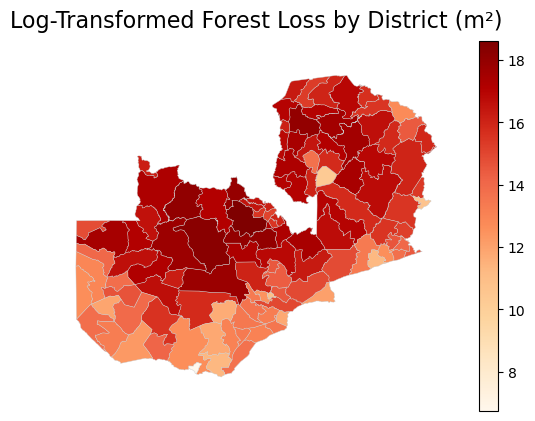

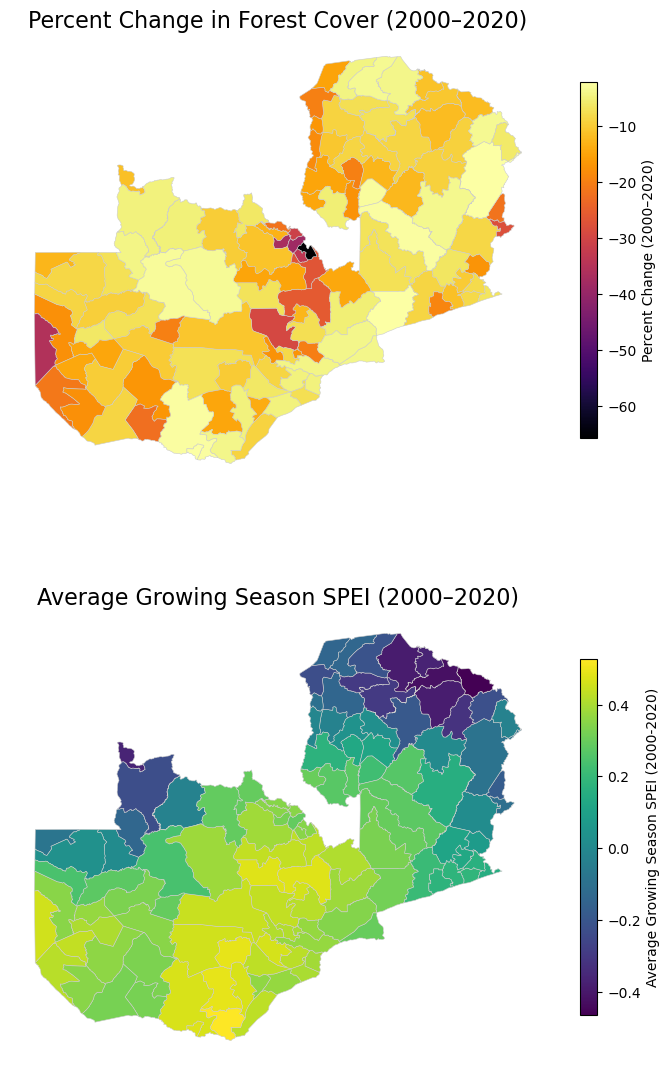

In [9]:
# plot choropleth
plt.figure(figsize=(20, 16))
merged.plot(column='log_loss_m2', cmap='OrRd', linewidth=0.3, edgecolor='0.8', legend=True)
plt.title('Log-Transformed Forest Loss by District (m²)', fontsize=16, pad=24)
plt.axis('off')
plt.show()

vmin_pc = max(merged['percent_change'].min(), -100)
vmax_pc = min(merged['percent_change'].max(), 0)

vmin_spei = merged_spei['mean_growing_spei'].min()
vmax_spei = merged_spei['mean_growing_spei'].max()   

fig, axes = plt.subplots(2,1, figsize=(7, 12))

merged.plot(
    column='percent_change',
    ax=axes[0],
    cmap='inferno',
    linewidth=0.4,
    edgecolor='0.8',
    legend=True,
    vmin=vmin_pc,
    vmax=vmax_pc,
    legend_kwds={'label': "Percent Change (2000–2020)", 'shrink': 0.6}
)

merged_spei.plot(
    column='mean_growing_spei',
    ax=axes[1],
    cmap='viridis',
    linewidth=0.4,
    edgecolor='0.8',
    legend=True,
    vmin=vmin_spei,
    vmax=vmax_spei,
    legend_kwds={'label': 'Average Growing Season SPEI (2000-2020)', 'shrink': 0.6}
)

axes[0].set_title('Percent Change in Forest Cover (2000–2020)', fontsize=16)
axes[1].set_title('Average Growing Season SPEI (2000–2020)', fontsize=16)
axes[0].axis('off')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Lag Comparisons

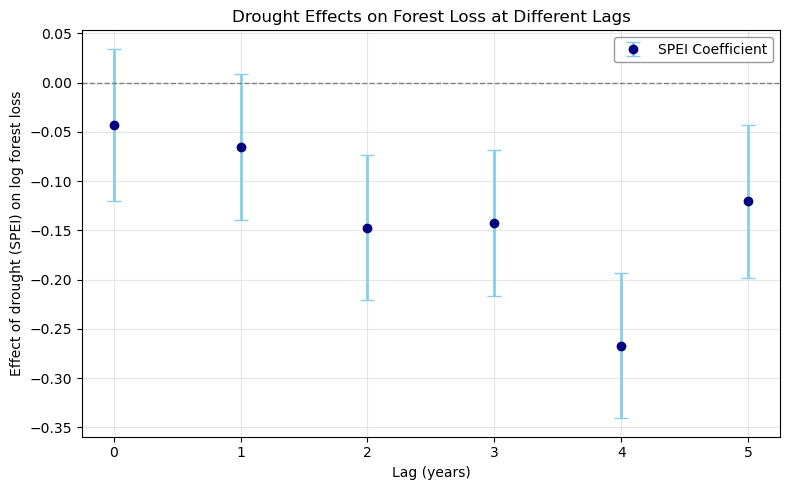

In [15]:
# load dataset
cleaned = pd.read_csv('regression_predictors.csv')

# log-transformed outcome
cleaned['log_loss_m2'] = np.log1p(cleaned['loss_m2'])

cleaned = cleaned.sort_values(['district', 'year'])

# create lag 0 column
cleaned['mean_spei_lag0'] = cleaned.groupby('district')['mean_spei_lag1'].shift(-1)

# define lags to test
lags = [0, 1, 2, 3, 4, 5]

# create empty list to store results
rows = []
for i in lags:
    spei_name = f'mean_spei_lag{i}'
    formula = (
        f'log_loss_m2 ~ {spei_name} + pop_density_wi + percent_forest_2000 + C(district)'
    )
    model = smf.ols(formula, data=cleaned).fit()

    rows.append({
        'lag': i,
        'coef': model.params.get(spei_name, np.nan),
        'se': model.bse.get(spei_name, np.nan),
        'pval': model.pvalues.get(spei_name, np.nan),
        'r2': model.rsquared,
        'adj_r2': model.rsquared_adj
    })

lag_comparison = pd.DataFrame(rows)

lag_comparison['ci_lower'] = lag_comparison['coef'] - 1.96 * lag_comparison['se']
lag_comparison['ci_upper'] = lag_comparison['coef'] + 1.96 * lag_comparison['se']

plt.figure(figsize=(8, 5))

# coefficient estimates and 95% CI
plt.errorbar(
    lag_comparison['lag'],
    lag_comparison['coef'],
    yerr=1.96 * lag_comparison['se'],
    fmt='o',
    color='navy',        
    ecolor='skyblue',   
    elinewidth=2,
    capsize=5,
    markersize=6,
    label='SPEI Coefficient'
)

# zero reference line
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# labels
plt.xticks(lag_comparison['lag'])
plt.xlabel('Lag (years)')
plt.ylabel('Effect of drought (SPEI) on log forest loss')
plt.title('Drought Effects on Forest Loss at Different Lags')
plt.grid(alpha=0.3)
plt.legend(frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout()
plt.show()

## Log loss vs. growing season SPEI averages

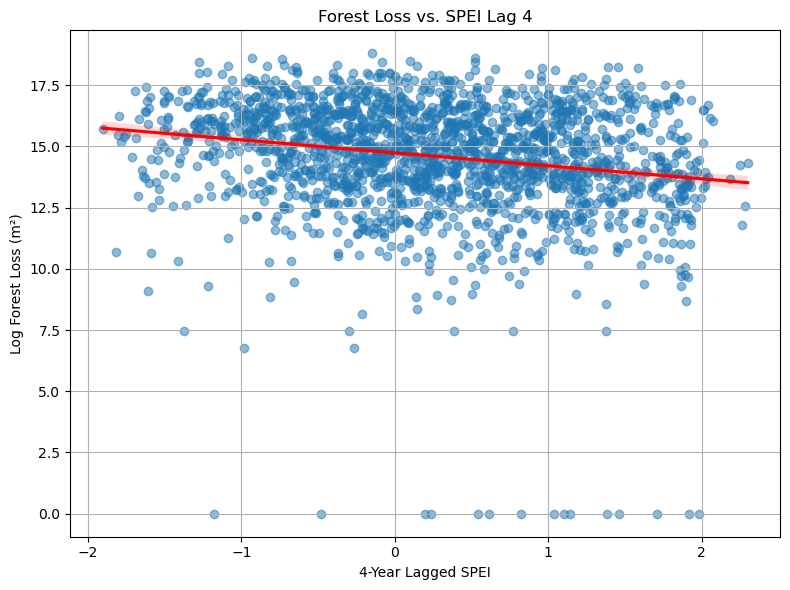

In [16]:
plt.figure(figsize=(8,6))
sns.regplot(data=cleaned, x='mean_spei_lag4', y='log_loss_m2', scatter_kws={'alpha': 0.5}, line_kws={'color':'red'})
plt.xlabel('4-Year Lagged SPEI')
plt.ylabel('Log Forest Loss (m²)')
plt.title('Forest Loss vs. SPEI Lag 4')
plt.grid(True)
plt.tight_layout()
plt.show()

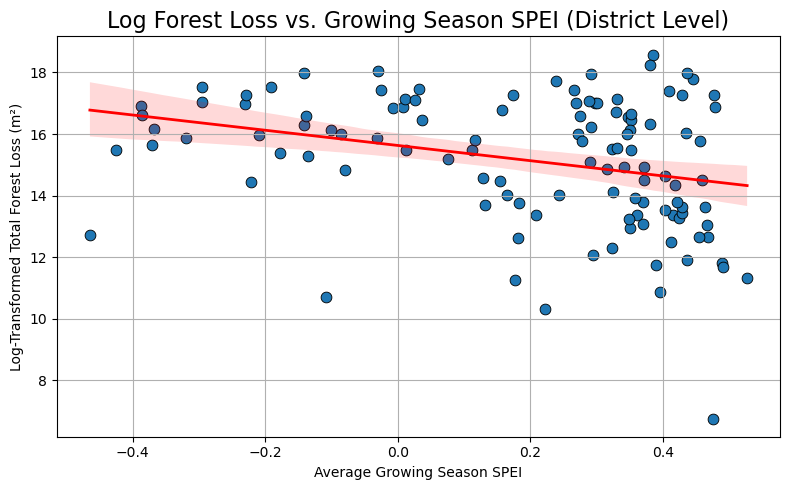

In [5]:
# log-transform forest loss
merged_spei['log_loss_m2'] = np.log1p(merged_spei['loss_m2'])

plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_spei, x='mean_growing_spei', y='log_loss_m2', s=60, edgecolor='black')
sns.regplot(data=merged_spei, x='mean_growing_spei', y='log_loss_m2', scatter=False, color='red', line_kws={'linewidth': 2})

plt.xlabel('Average Growing Season SPEI')
plt.ylabel('Log-Transformed Total Forest Loss (m²)')
plt.title('Log Forest Loss vs. Growing Season SPEI (District Level)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

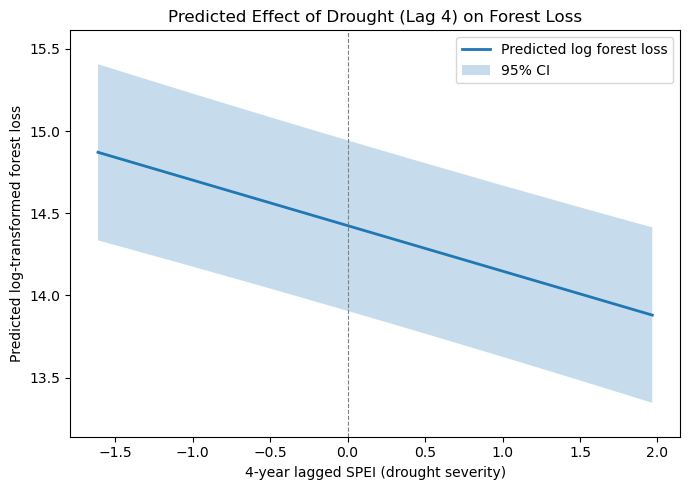

In [17]:
spei_col = 'mean_spei_lag4'
pop_col = 'pop_density_wi'
inter_col = 'spei4_x_popdens'
forest_col = 'percent_forest_2000'
district_col = 'district'

spei_min, spei_max = cleaned[spei_col].quantile([0.01, 0.99])
spei_grid = np.linspace(spei_min, spei_max, 200)

pop_mean = cleaned[pop_col].mean()
forest_mean = cleaned[forest_col].mean()
baseline_district = cleaned[district_col].mode().iat[0]

# build prediction frame
pred_df = pd.DataFrame({
    spei_col: spei_grid,
    pop_col: pop_mean,
    forest_col: forest_mean,
    inter_col: spei_grid * pop_mean,
    district_col: baseline_district
})

# predictions and 95% CI
pred_res = model_log.get_prediction(pred_df).summary_frame(alpha=0.05)

# compute tight y-limits from CI band + small padding
y_min = float(pred_res["mean_ci_lower"].min())
y_max = float(pred_res["mean_ci_upper"].max())
padding = (y_max - y_min) * 0.10 if (y_max - y_min) > 0 else 0.5  # fallback padding if very flat

# plot
plt.figure(figsize=(7, 5))
plt.plot(spei_grid, pred_res["mean"], label="Predicted log forest loss", linewidth=2.0)
plt.fill_between(
    spei_grid, pred_res["mean_ci_lower"], pred_res["mean_ci_upper"],
    alpha=0.25, label="95% CI"
)

# reference lines
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)

# apply tighter y-limits to remove negative space
plt.ylim(y_min - padding, y_max + padding)

plt.xlabel('4-year lagged SPEI (drought severity)')
plt.ylabel('Predicted log-transformed forest loss')
plt.title('Predicted Effect of Drought (Lag 4) on Forest Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Baseline forest cover vs. log forest loss

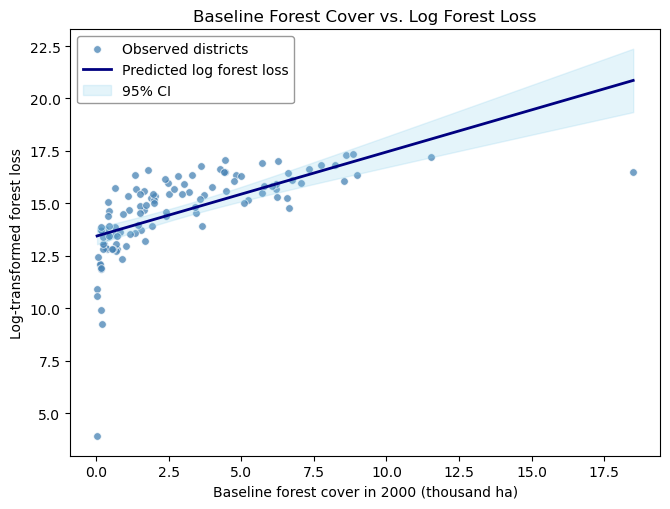

In [23]:
x_col   = "percent_forest_2000"  
y_col   = "log_loss_m2"
group_col = "district"
title   = "Baseline Forest Cover vs. Log Forest Loss"
x_label = "Baseline forest cover in 2000 (thousand ha)"
y_label = "Log-transformed forest loss"

# one row per unit
avg = (cleaned[[group_col, x_col, y_col]]
       .dropna()
       .groupby(group_col, as_index=False)
       .mean())

# convert m² -> thousand hectares 
avg['forest_2000_kha'] = avg[x_col] / 1e7

# fit linear model in original units (m²)
X = sm.add_constant(avg[x_col].values)   
y = avg[y_col].values
model = sm.OLS(y, X).fit()

# build a grid in kha for plotting, but predict in m²
x_grid_kha = np.linspace(avg['forest_2000_kha'].min(),
                         avg['forest_2000_kha'].max(), 200)
X_grid = sm.add_constant(x_grid_kha * 1e7)  # back to m² for prediction
pred = model.get_prediction(X_grid).summary_frame(alpha=0.05)

# plot
plt.figure(figsize=(6.8, 5.2))

# scatterplot of observed data
plt.scatter(
    avg['forest_2000_kha'], avg[y_col],
    s=30, alpha=0.75,
    color='steelblue', edgecolor='white', linewidth=0.6,
    label='Observed districts'
)

# regression line
plt.plot(
    x_grid_kha, pred['mean'],
    linewidth=2, color='navy',
    label='Predicted log forest loss'
)

# 95% confidence interval
plt.fill_between(
    x_grid_kha,
    pred['mean_ci_lower'],
    pred['mean_ci_upper'],
    alpha=0.22,
    color='skyblue',
    label='95% CI'
)

# axis labels & title
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

# legend formatting
plt.legend(
    frameon=True,
    facecolor='white',
    edgecolor='gray',
    fontsize=10,
    loc='upper left'
)

# format ticks
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.1f}"))

plt.tight_layout()
plt.show()